In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
from scipy import ndimage
from util import pyvis
from util import extract

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
reextract = 0
reload = 0
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/media/mts_dbs/dbs/complete_cases/nii/qsm/'
s_directory = '/media/mts_dbs/dbs/complete_cases/nii/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)

case_list = []
d_count = 0
if reload == 1:
    for qsm_filename in q_directory:
        id = qsm_filename[4:6]
        seg_filepath = '/media/mts_dbs/dbs/complete_cases/nii/seg/labels_2iMag'+str(id)+'.nii.gz'
        qsm_filepath = '/media/mts_dbs/dbs/complete_cases/nii/qsm/qsm_'+str(id)+'.nii.gz'
        if os.path.isfile(qsm_filepath) and os.path.isfile(seg_filepath):
  
            qsm = nib.load('/media/mts_dbs/dbs/complete_cases/nii/qsm/'+qsm_filename)
            seg = nib.load(seg_filepath)
            voxel_size = seg.header['pixdim'][0:3]
            voxel_sizes.append(voxel_size)
            segs.append(seg.get_fdata())
            qsms.append(qsm.get_fdata())
            print('Appending arrays with segmentation','labels2_iMag'+str(id)+'.nii.gz','and QSM',qsm_filename)
            case_list.append('qsm_'+str(id)+'.nii.gz')
            n_cases = len(segs)
            d_count = d_count+1
            try:
                next
                # qsms_wl = np.asarray(qsms)
                # segs_wl = np.asarray(segs)
            except:
                print('Failed to append QSM at case',str(id))
            with open('./pickles/segs_all', 'wb') as fp:  
                pickle.dump(segs, fp)

            with open('./pickles/qsms_all', 'wb') as fp:  
                pickle.dump(qsms, fp)
        else:
            print('Skipping missing case',str(id))

else:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/segs_all', "rb") as fp:  
        segs = pickle.load(fp)

    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/qsms_all', "rb") as fp:  
        qsms = pickle.load(fp)

In [4]:
if visualize == 1:
    qsms_wl = np.asarray(qsms)
    segs_wl = np.asarray(segs)
    qsms_wl[qsms_wl < m1] = m1
    qsms_wl[qsms_wl > m2] = m2
    n_cases = len(segs)
    multi_slice_viewer(np.hstack(((np.vstack(qsms_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(qsms_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T))))
   
                                    
    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

In [5]:
file_dir = '/data/Ali/RadDBS-QSM/src/csv'
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('QSM anonymus- 6.22.2023-1528.csv')

In [6]:
# Make a copy
dfd = df.copy()
# Drop blank columns
for (columnName, columnData) in dfd.iteritems():
    if columnData.isnull().all():
        print('Dropping NaN column at',columnName)
        dfd.drop(columnName,axis=1,inplace=True)
# Add relevant column names from headers
for (columnName, columnData) in dfd.iteritems():
        dfd.rename(columns={columnName:columnName+': '+columnData.values[0]},inplace=True)

def drop_prefix(self, prefix):
    self.columns = self.columns.str.lstrip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

dfd.drop_prefix('Unnamed:')        
for (columnName, columnData) in dfd.iteritems():
    if columnName[1].isdigit():
        dfd.rename(columns={columnName:columnName[4:]},inplace=True)

# Make a copy for motor symptoms
motor_df = dfd.copy()
# Drop non-motor (III) columns
for (columnName, columnData) in motor_df.iteritems():
    if 'pre-dbs updrs' in columnName:
        next
    elif 'stim' in columnName:
        next
    elif 'CORNELL ID' in columnName:
        next
    else:
        motor_df.drop(columnName,axis=1,inplace=True)

# Drop subheader
motor_df = motor_df.tail(-1)
motor_df = motor_df.replace('na',np.nan)
motor_df

,CORNELL ID,OFF (pre-dbs updrs),ON (pre-dbs updrs),OFF meds ON stim 6mo,ON meds ON stim 6mo,off stim on med 6mo,off stim off med 6mo
1,67,60,41,31,29,NaN,NaN
2,only Ct data,43,12,NaN,20,18,NaN
3,74,34,11,NaN,17,NaN,NaN
4,84,53,13,NaN,34,NaN,NaN
5,75,62,8,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...
87,52,58,27,19,12,NaN,NaN
88,53,77,47,NaN,19,26,NaN
89,54,63,36,8,NaN,NaN,NaN
90,55,40,29,NaN,13,NaN,37


In [7]:
id = []
x_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X')
for filename in x_directory:
    id.append(filename[14:][:-4])
df_post_dbs_off_meds_on_stim = motor_df['OFF meds ON stim 6mo'].to_numpy().astype('float')
df_post_dbs_off_meds_off_stim = motor_df[' off stim off med 6mo'].to_numpy().astype('float')
df_pre_dbs_off_meds = motor_df['OFF (pre-dbs updrs)'].to_numpy().astype('float')
df_pre_dbs_on_meds = motor_df['ON (pre-dbs updrs)'].to_numpy().astype('float')

cases = ~np.isnan(df_pre_dbs_off_meds+df_pre_dbs_on_meds+df_post_dbs_off_meds_on_stim)
pre_dbs_meds_improvement = (df_pre_dbs_off_meds[cases]-df_pre_dbs_on_meds[cases])/df_pre_dbs_off_meds[cases]
dbs_off_meds_improvement = (df_pre_dbs_off_meds[cases]-df_post_dbs_off_meds_on_stim[cases])/df_pre_dbs_off_meds[cases]
motor_df['CORNELL ID'].replace('only Ct data ', np.nan, inplace=True)
pids = motor_df['CORNELL ID'].to_numpy().astype('float')
subs = pids[cases]
subs_in = (np.intersect1d(subs,np.asarray(id).astype(float)))
df_pre_dbs_off_meds_in = df_pre_dbs_off_meds[cases]
pre_dbs_off_meds_in = df_pre_dbs_off_meds_in[np.in1d(subs,np.asarray(id).astype(float))]

In [8]:
if reextract == 1:
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)

    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    roi_txt = pd.read_csv("/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv")
    roi_df = roi_txt.astype(str)
    packet = [*zip(qsms,segs,subs_in,pre_dbs_off_meds_in)]
    def extract(qsm,seg,sub_in,pre_dbs_off_meds_in):
        fv_count = 0
        seg_labels_all = [0,1,2,3,4,5,6,7]
        Phi_gt = []
        x_row_gt = []
        keylib = []
        roilib = []
        roi_names = []
        voxel_size = ((0.5,0.5,0.5))
        seg_sitk = sitk.GetImageFromArray(seg)
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsm)
        qsm_sitk_gt.SetSpacing(voxel_size)
        for j in seg_labels_all:
            if 0 < j < 7:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(j)
                        mask = np.row_stack([roi_df[row].str.contains(str(int(roilib[-1])), na = False) for row in roi_df])
                        roi_names.append(np.asarray(roi_df.iloc[mask.any(axis=0),1])[0])
                x_row_gt.append(pre_dbs_off_meds_in)
                fv_count = fv_count+1
                print('Extracting features for subject',sub_in,
                    'ROI',j,'and appending feature matrix with vector of length',
                    fv_count,'with UPDRS score',pre_dbs_off_meds_in)

        X0_gt = np.array(x_row_gt)
        npy_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/X0_gt_msw_rois'+str(sub_in)+'.npy'
        np.save(npy_file,X0_gt)
        K = np.asarray(keylib)
        R = np.asarray(roi_names)
        K_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/K_msw'+str(sub_in)+'.npy'
        R_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/R_msw'+str(sub_in)+'.npy'
        np.save(K_file,K)
        np.save(R_file,R)
        Phi_file = '/data/Ali/RadDBS-QSM/src/jupyter/phi/Phi_mcl_gt_roi_msw'+str(sub_in)
        print('Saving ground truth feature vector')
        with open(Phi_file, 'wb') as fp:  
            pickle.dump(Phi_gt, fp)

    pool = Pool(os.cpu_count()-1)
    results = pool.starmap(extract,packet,TimeoutError)

    

In [9]:
Phi_all = []
n_rois = 6
n_features = 1596
n_cases = 35
X_all = np.zeros((n_cases,n_rois,n_features))
R_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
K_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
phi_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new')
X_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X')
R_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R')
K_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K')
# Load all feature structures
for feature_matrix in phi_directory:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new/'+feature_matrix, "rb") as fp:  
        Phi_case = pickle.load(fp)
        Phi_all.append(Phi_case)

# Load feature arrays
count = 0
for feature_array in X_directory:
    X_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X/'+feature_array)
    X_all[count,:,:] = X_case.reshape((n_rois,n_features)).transpose((0,1))
    count = count+1

# Load ROI indices
count = 0
for feature_roi in R_directory:
    R_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R/'+feature_roi)
    R_all[count,:,:] = R_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1

# Load key indices
count = 0
for feature_key in K_directory:
    K_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K/'+feature_key)
    K_all[count,:,:] = K_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1


In [10]:
n_cases_train = n_cases-5

In [11]:
ut_ls = np.zeros((n_cases-n_cases_train))
ut_qr = np.zeros((n_cases-n_cases_train))

# Normalize training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all_r = X_all[:n_cases_train,:,:].reshape(n_cases_train,((n_features)*n_rois))
scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_all_t = scaler.fit_transform(X_all_r)


In [12]:
dbs_off_meds_improvement_in = dbs_off_meds_improvement[np.in1d(subs,np.asarray(id).astype(float))]
pre_dbs_meds_improvement_in = pre_dbs_meds_improvement[np.in1d(subs,np.asarray(id).astype(float))]

In [13]:
dbs_off_meds_improvement_in[:n_cases_train]

array([0.48333333, 0.74545455, 0.74358974, 0.14705882, 0.85294118,
       0.53125   , 0.5       , 0.26086957, 0.52272727, 0.19444444,
       0.55932203, 0.76086957, 0.66153846, 0.83928571, 0.08571429,
       0.15686275, 0.35897436, 0.48      , 0.83076923, 0.90909091,
       0.55555556, 0.95238095, 0.88888889, 0.59259259, 0.5       ,
       0.87878788, 0.88311688, 0.80357143, 0.66666667, 0.69135802])

In [14]:
dbs_off_meds_improvement_in[n_cases_train:]

array([0.42857143, 0.1875    , 0.93939394, 0.55555556, 0.67241379])

In [15]:
# Create data frame for SMOGN generation
dbs_off_meds_improvement_in_train = dbs_off_meds_improvement_in[0:n_cases_train]
pre_dbs_meds_improvement_in_train = pre_dbs_meds_improvement[0:n_cases_train]
D = pd.DataFrame(np.hstack((X_all_t,(dbs_off_meds_improvement_in_train.reshape(n_cases_train,1)))))
for col in D.columns:
    D.rename(columns={col:str(col)},inplace=True)

# Specify phi relevance values
Rm = [[np.min(dbs_off_meds_improvement_in_train),  1, 0],  ## over-sample ("minority")
    [np.median(dbs_off_meds_improvement_in_train), 0, 0],  ## under-sample ("majority")
    ]

# Conduct SMOGN
print('Prior to SMOGN sampling, mean is',X_all_t.mean(),'standard deviation is',X_all_t.std())
X_smogn = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm)

# Drop label
X_in_s = np.array(X_smogn)[:,:-1] 
print('After SMOGN sampling, mean is',X_in_s.mean(),'standard deviation is',X_in_s.std())
X_in_s = scaler.fit_transform(np.vstack((X_in_s,X_all_t)))
print('Standardizing the SMOGN dataset gives, mean',X_in_s.mean(),'standard deviation',X_in_s.std())

for j in np.arange(X_in_s.shape[1]):
    if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
        next
    else:
        print('Labels detected at column',j)

Prior to SMOGN sampling, mean is 8.587456065716611e-17 standard deviation is 0.9593883807733483


synth_matrix: 100%|##########| 5/5 [00:12<00:00,  2.43s/it]
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


After SMOGN sampling, mean is 0.07542183168274966 standard deviation is 0.8496134124354202
Standardizing the SMOGN dataset gives, mean -3.453689913317112e-18 standard deviation 0.9593883807733484


In [16]:
X_in_s.shape

(55, 9576)

In [ ]:
Cs = np.zeros_like(X_in_s)
C = np.zeros_like(X_all_t)
cv = KFold(n_splits=X_in_s.shape[0]-1,shuffle=True)
smogn_per_change_in = np.asarray(X_smogn)[:,-1]
clf_s = LassoCV(max_iter=10000,cv=cv,n_jobs=-1,verbose=True).fit(X_in_s,np.vstack((smogn_per_change_in,per_change_in)))
print(clf_s.score(X_in_s,np.vstack((smogn_per_change_in,dbs_off_meds_improvement_in[:n_cases_train]))))
# Get the features LASSO-SMOGN uses
Cs = clf_s.coef_


NameError: name 'per_change_in' is not defined

In [ ]:
X_all_q = scaler.fit_transform(X_all[n_cases_train:,:,:].reshape(n_cases-n_cases_train,((n_features)*n_rois)))
ut_ls = clf_s.predict(X_all_q)

In [ ]:
dbs_target = dbs_off_meds_improvement_in[n_cases_train:]

<function matplotlib.pyplot.show(close=None, block=None)>

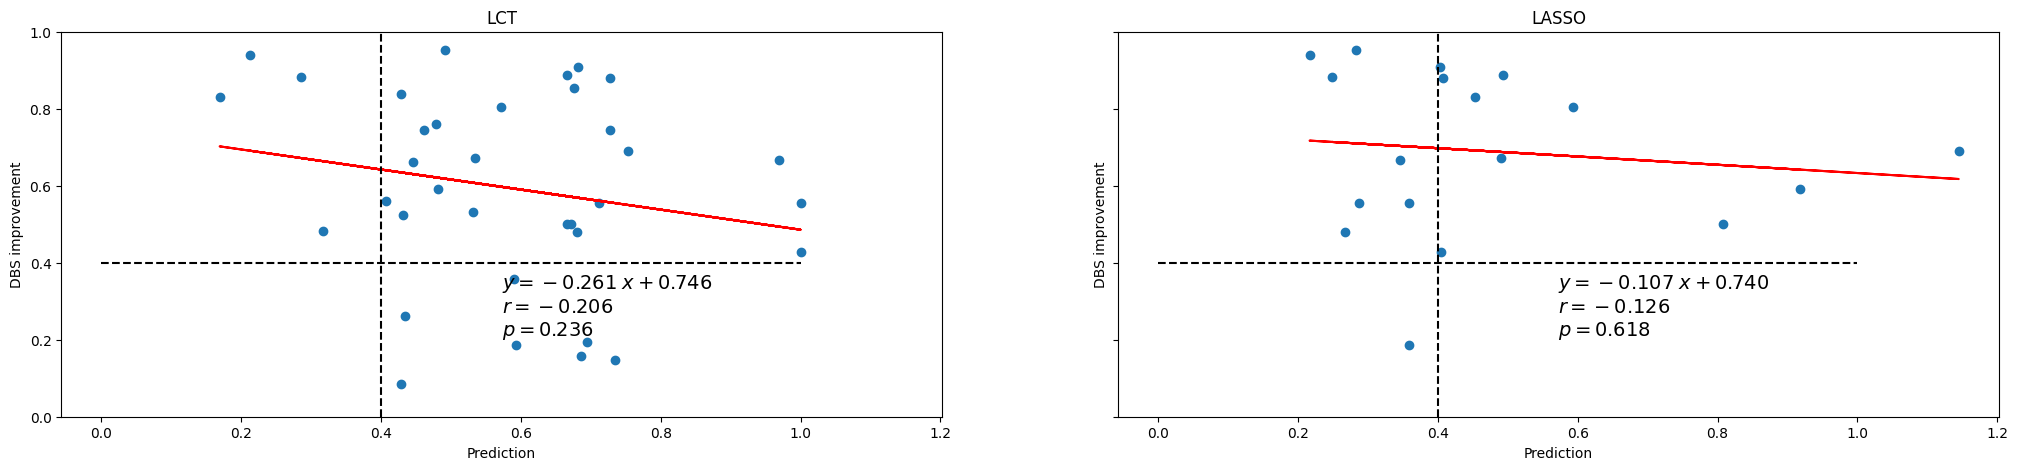

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
lr_prepost = linregress(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in)
ax[0].scatter(pre_dbs_meds_improvement_in,dbs_off_meds_improvement_in,)
ax[0].plot(pre_dbs_meds_improvement_in,pre_dbs_meds_improvement_in*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.5, 0.375, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.4,0,1,linestyle='dashed',color='black')
ax[0].vlines(0.4,0,2,linestyle='dashed',color='black')

lr_pred_ls = linregress(ut_ls,dbs_target)
ax[1].scatter(ut_ls,dbs_target)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.5, 0.375, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.4,0,1,linestyle='dashed',color='black')
ax[1].vlines(0.4,0,2,linestyle='dashed',color='black')


plt.style.use('default')
plt.show